In [1]:
import os
import dendropy
from Bio.Align.Applications import MafftCommandline
from Bio.Align.Applications import MuscleCommandline
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from collections import OrderedDict
from dendropy.interop import genbank
import matplotlib.pyplot as plt
from Bio import Phylo
import numpy as np
import pandas as pd
import random
import shutil
import sys
from dendropy.calculate import popgenstat
from Bio.Phylo.Applications import RaxmlCommandline
from dendropy.interop import raxml
from collections import deque
from copy import deepcopy
from collections import OrderedDict
import subprocess

/home/veysel/.local/lib/python3.12/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(
/home/veysel/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## **Working with GenBank Molecular Sequence Databases**

The genbank module provides the classes and methods to download sequences from GenBank and instantiate them into DendroPy phylogenetic data objects. Three classes are provided, all of which have an identical interface, varying only in the type of data retrieved:

**GenBankDna**

        Acquire and manage DNA sequence data from the GenBank Nucleotide database.

**GenBankRna**

        Acquire and manage RNA sequence data from the GenBank Nucleotide database.

**GenBankProtein**

        Acquire and manage AA sequence data from the GenBank Protein database.

**Acquiring Data from GeneBank**

The GenBankDna, GenBankRna, and GenBankProtein classes provide for the downloading and management of DNA, RNA, and protein (AA) sequences from GenBank. The first two of these query the “nucleotide” or “nuccore” database, while the last queries the “protein” database. The constructors of these classes accept the following arguments:

**ids**

        A list of accession identifiers of GI numbers of the records to be downloaded. E.g. “ids=['EU105474', 'EU105475']”, “ids=['158930545', 'EU105475']”, or “ids=['158930545', '158930546']”. If “prefix” is specified, this string will be pre-pended to all values in the list.

**id_range**

        A tuple of integers that specify the first and last values (inclusive) of accession or GI numbers of the records to be downloaded. If “prefix” is specified, this string will be prepended to all numbers in this range. Thus specifying “id_range=(158930545, 158930550)” is exactly equivalent to specifying “ids=[158930545, 158930546, 158930547, 158930548, 158930549, 158930550]”, while specifying “id_range=(105474, 105479), prefix="EU"” is exactly equivalent tp specifying “ids=["EU105474", "EU105475", "EU105476", "EU105477", "EU105478", "EU105479"]”.
    
**prefix**

        This string will be prepended to all values resulting from the “ids” and “id_range”.
    
    
**verify**

        By default, the results of the download are checked to make sure there is a one-to-one correspondence between requested id’s and retrieved records. Setting “verify=False” skips this checking.



In [2]:
def get_ebov_2014_sources():
    #EBOV_2014
    #yield 'EBOV_2014', genbank.GenBankDna(id_range=(233036, 233118), prefix='KM')
    yield 'EBOV_2014', genbank.GenBankDna(id_range=(34549, 34563), prefix='KM0')
    
def get_other_ebov_sources():
    #EBOV other
    yield 'EBOV_1976', genbank.GenBankDna(ids=['AF272001', 'KC242801'])
    yield 'EBOV_1995', genbank.GenBankDna(ids=['KC242796', 'KC242799'])
    yield 'EBOV_2007', genbank.GenBankDna(id_range=(84, 90), prefix='KC2427')
    
def get_other_ebolavirus_sources():
    #BDBV
    yield 'BDBV', genbank.GenBankDna(id_range=(3, 6), prefix='KC54539')
    yield 'BDBV', genbank.GenBankDna(ids=['FJ217161'])

    #RESTV
    yield 'RESTV', genbank.GenBankDna(ids=['AB050936', 'JX477165', 'JX477166', 'FJ621583', 'FJ621584', 'FJ621585']) 

    #SUDV
    yield 'SUDV', genbank.GenBankDna(ids=['KC242783', 'AY729654', 'EU338380',
                                          'JN638998', 'FJ968794', 'KC589025', 'JN638998'])
    #yield 'SUDV', genbank.GenBankDna(id_range=(89, 92), prefix='KC5453')    

    #TAFV
    yield 'TAFV', genbank.GenBankDna(ids=['FJ217162'])

**Iteration Over Sources:**
The function get_other_ebolavirus_sources() is a generator that yields tuples of the form
(species, recs)
where:

    species is a string (e.g., 'RESTV', 'SUDV', 'BDBV', or 'TAFV').
    recs is an object of type genbank.GenBankDna that knows how to retrieve the DNA sequences from GenBank (using either an ID range or a list of IDs).

**Taxon Namespace:**
For each source, a new DendroPy TaxonNamespace object (tn) is created. This object will hold a collection of taxon objects (each corresponding to a GenBank record).

**Generating a Character Matrix:**
The method

recs.generate_char_matrix(taxon_namespace=tn, gb_to_taxon_fn=...)

converts the GenBank records into a DendroPy character matrix (specifically, a DnaCharacterMatrix).

    The gb_to_taxon_fn is a lambda function that, given a GenBank record (gb), creates or retrieves a taxon in tn with a label formed by concatenating the species name and the GenBank accession (e.g., "RESTV_AB050936").

**Writing Sequences:**
The character matrix (char_mat) is then written to two file streams in FASTA format:

    First, to other.fasta (which will contain only these “other” ebolavirus sequences).
    Second, to sample.fasta (a combined file of sequences from all sources).

In [3]:
other = open('other.fasta', 'w')
sampled = open('sample.fasta', 'w')

for species, recs in get_other_ebolavirus_sources():
    tn = dendropy.TaxonNamespace()
    char_mat = recs.generate_char_matrix(taxon_namespace=tn,
        gb_to_taxon_fn=lambda gb: tn.require_taxon(label='%s_%s' % (species, gb.accession)))
    char_mat.write_to_stream(other, 'fasta')
    char_mat.write_to_stream(sampled, 'fasta')
other.close()
ebov_2014 = open('ebov_2014.fasta', 'w')
ebov = open('ebov.fasta', 'w')
for species, recs in get_ebov_2014_sources():
    tn = dendropy.TaxonNamespace()
    char_mat = recs.generate_char_matrix(taxon_namespace=tn,
        gb_to_taxon_fn=lambda gb: tn.require_taxon(label='EBOV_2014_%s' % gb.accession))
    char_mat.write_to_stream(ebov_2014, 'fasta')
    char_mat.write_to_stream(sampled, 'fasta')
    char_mat.write_to_stream(ebov, 'fasta')
ebov_2014.close()

ebov_2007 = open('ebov_2007.fasta', 'w')
for species, recs in get_other_ebov_sources():
    tn = dendropy.TaxonNamespace()
    char_mat = recs.generate_char_matrix(taxon_namespace=tn,
        gb_to_taxon_fn=lambda gb: tn.require_taxon(label='%s_%s' % (species, gb.accession)))
    char_mat.write_to_stream(ebov, 'fasta')
    char_mat.write_to_stream(sampled, 'fasta')
    if species == 'EBOV_2007':
        char_mat.write_to_stream(ebov_2007, 'fasta')

ebov.close()
ebov_2007.close()
sampled.close()

**What the Function Does**

**Inputs:**
        species: A string representing the viral species (e.g., 'RESTV' or 'SUDV').
        recs: A collection of GenBank record objects (produced by a genbank.GenBankDna object). Each record contains a feature_table with annotated features.
        g_dls: A dictionary mapping gene names (e.g., 'NP') to file handles for writing nucleotide sequences.
        p_hdls: A dictionary mapping gene names to file handles for writing protein sequences.

**Processing Steps:**
        Loop Over Records:
        For each record (rec) in the provided collection recs:
        Loop Over Features:
        The code iterates over each feature in the record’s feature_table.
            It checks if feature.key == 'CDS'. Only coding sequences (CDS) are of interest.
        Examine Qualifiers:
        For each CDS feature, it initializes gene_name as None and then loops over the feature’s qualifiers (attributes).
            If the qualifier name is 'gene':
            It checks if the qualifier’s value (the gene symbol) is in my_genes. If yes, it sets gene_name to that value.
            If the qualifier name is 'translation':
            It extracts the protein translation (a string of amino acids) and stores it in protein_translation.
        If a Target Gene Is Found:
        After examining all qualifiers, if gene_name is not None (meaning this CDS belongs to one of the target genes):
            Extract Coordinates:
            The code takes feature.location, which is expected to be a string with start and end positions separated by a dot (e.g., "100.500"). It splits this string and converts the first and last tokens into integers.
                Note on Indexing:
                The code then extracts the nucleotide sequence from rec.sequence_text using start - 1 : end because GenBank coordinates are 1-based while Python slicing is 0-based.
            Write FASTA Headers and Sequences:
                For the nucleotide file:
                It writes a FASTA header of the form >species_accession (e.g., >RESTV_AB050936), then writes the nucleotide sequence.
                For the protein file:
                It writes a similar header and then writes the protein translation.

**Two dictionaries are created:**
        g_hdls: Will hold file handles for nucleotide sequences.
        p_hdls: Will hold file handles for protein sequences.
**For each gene in my_genes, the code opens two files for writing:**
        For example, for gene 'NP', it opens:
            "NP.fasta" for the nucleotide sequence.
            "NP_P.fasta" for the protein sequence.

Purpose:
This prepares output files so that when dump_genes writes sequence data, the appropriate files are already open.

In [3]:
my_genes = ['NP', 'L', 'VP35', 'VP40']

def dump_genes(species, recs, g_dls, p_hdls):
    for rec in recs:

        for feature in rec.feature_table:
                    if feature.key == 'CDS':
                        gene_name = None
                        for qual in feature.qualifiers:
                            if qual.name == 'gene':
                                if qual.value in my_genes:
                                    gene_name = qual.value
                            elif qual.name == 'translation':
                                protein_translation = qual.value
                        if gene_name is not None:
                            locs = feature.location.split('.')
                            start, end = int(locs[0]), int(locs[-1])
                            g_hdls[gene_name].write('>%s_%s\n' % (species, rec.accession))
                            p_hdls[gene_name].write('>%s_%s\n' % (species, rec.accession))
                            g_hdls[gene_name].write('%s\n' % rec.sequence_text[start - 1 : end])
                            p_hdls[gene_name].write('%s\n' % protein_translation)

g_hdls = {}
p_hdls = {}
for gene in my_genes:
    g_hdls[gene] = open('%s.fasta' % gene, 'w')
    p_hdls[gene] = open('%s_P.fasta' % gene, 'w')
for species, recs in get_other_ebolavirus_sources():
    if species in ['RESTV', 'SUDV']:
        dump_genes(species, recs, g_hdls, p_hdls)
for gene in my_genes:
    g_hdls[gene].close()
    p_hdls[gene].close()

In [4]:
def describe_seqs(seqs):
    print('Number of sequences: %d' % len(seqs.taxon_namespace))
    print('First 10 taxon sets: %s' % ' '.join([taxon.label for taxon in seqs.taxon_namespace[:10]]))
    lens = []
    for tax, seq in seqs.items():
        """
        For each taxon–sequence pair in the matrix, it converts the sequence to a list of 
        symbols (e.g., ['A', 'C', 'G', 'T', ...]) and counts all symbols that are not a 
        gap ('-'). It collects these lengths into a list and then prints the minimum, 
        mean, and maximum sequence lengths.
        """
        lens.append(len([x for x in seq.symbols_as_list() if x != '-']))
    print('Genome length: min %d, mean %.1f, max %d' % (min(lens), sum(lens) / len(lens), max(lens)))


In [5]:
ebov_seqs = dendropy.DnaCharacterMatrix.get_from_path('ebov.fasta', schema='fasta', data_type='dna')
print('EBOV')
describe_seqs(ebov_seqs)
del ebov_seqs

EBOV
Number of sequences: 26
First 10 taxon sets: EBOV_2014_KM034549 EBOV_2014_KM034550 EBOV_2014_KM034551 EBOV_2014_KM034552 EBOV_2014_KM034553 EBOV_2014_KM034554 EBOV_2014_KM034555 EBOV_2014_KM034556 EBOV_2014_KM034557 EBOV_2014_KM034558
Genome length: min 18700, mean 18925.2, max 18959


In [6]:
print('ebolavirus sequences')
ebolav_seqs = dendropy.DnaCharacterMatrix.get_from_path('other.fasta', schema='fasta', data_type='dna')
describe_seqs(ebolav_seqs)
from collections import defaultdict
species = defaultdict(int)
for taxon in ebolav_seqs.taxon_namespace:
    toks = taxon.label.split('_')
    my_species = toks[0]
    if my_species == 'EBOV':
        ident = '%s (%s)' % (my_species, toks[1])
    else:
        ident = my_species
    species[ident] += 1
for my_species, cnt in species.items():
    print("%20s: %d" % (my_species, cnt))
del ebolav_seqs

ebolavirus sequences
Number of sequences: 18
First 10 taxon sets: BDBV_KC545393 BDBV_KC545394 BDBV_KC545395 BDBV_KC545396 BDBV_FJ217161 RESTV_AB050936 RESTV_JX477165 RESTV_JX477166 RESTV_FJ621583 RESTV_FJ621584
Genome length: min 18796, mean 18892.7, max 18940
                BDBV: 5
               RESTV: 6
                SUDV: 6
                TAFV: 1


In [7]:
gene_length = {}
my_genes = ['NP', 'L', 'VP35', 'VP40']

for name in my_genes:
    gene_name = name.split('.')[0]
    seqs = dendropy.DnaCharacterMatrix.get_from_path('%s.fasta' % name, schema='fasta', data_type='dna')
    gene_length[gene_name] = []
    for tax, seq in seqs.items():
        gene_length[gene_name].append(len([x for x in seq.symbols_as_list() if x != '-']))
for gene, lens in gene_length.items():
    print ('%6s: %d' % (gene, sum(lens) / len(lens)))

    NP: 2218
     L: 6636
  VP35: 990
  VP40: 988


**MafftCommandline:**
Constructs a command-line call to MAFFT, a tool for multiple sequence alignment.

**input**='sample.fasta': Aligns the sequences in the file sample.fasta.
Other parameters:
**ep=0.123:** Sets an offset parameter that can affect gap penalties.
**reorder=True:** Allows MAFFT to reorder sequences based on similarity.
**maxiterate=1000:** Specifies the maximum number of iterative refinement steps.
**localpair=True:** Uses a local pairwise alignment strategy, which is appropriate for sequences with regions of high similarity.

Execution and Writing Output:
The command is executed, and the output (stdout) is written to a new FASTA file named align.fasta.
**ep value** refers to a parameter called "effective gap penalty" which controls how readily the alignment algorithm introduces gaps (insertions or deletions) between sequences, with a higher "ep" value generally leading to fewer gaps being inserted during alignment. 


In [10]:
mafft_cline = MafftCommandline(input='sample.fasta', ep=0.123, reorder=True, maxiterate=1000, localpair=True)
print(mafft_cline)
stdout, stderr = mafft_cline()
with open('align.fasta', 'w') as w:
    w.write(stdout)

os.system('trimal -automated1 -in align.fasta -out trim.fasta -fasta')

mafft --localpair --maxiterate 1000 --ep 0.123 --reorder sample.fasta


0

In [27]:
my_genes = ['NP', 'L', 'VP35', 'VP40']
muscle_path = "/usr/bin/muscle" 

for gene in my_genes:
    input_file = f"{gene}_P.fasta"
    output_file = f"{gene}_P_align.fasta"

    # Check if the input file exists and has valid FASTA sequences
    if not os.path.exists(input_file):
        print(f"Error: {input_file} does not exist.")
        continue

    if os.stat(input_file).st_size == 0:
        print(f"Error: {input_file} is empty.")
        continue

    with open(input_file, "r") as f:
        lines = f.readlines()
        if not any(line.startswith(">") for line in lines):
            print(f"Error: {input_file} does not contain valid FASTA sequences.")
            continue

    # Construct MUSCLE command
    cmd = [muscle_path, "-align", input_file, "-output", output_file]
    print("Running:", " ".join(cmd))  # Debugging statement

    try:
        result = subprocess.run(cmd, check=True, capture_output=True, text=True)
        if os.path.exists(output_file) and os.stat(output_file).st_size > 0:
            print(f"Success: {output_file} generated successfully.")
        else:
            print(f"Error: {output_file} was not created or is empty.")
            print("MUSCLE Output:", result.stdout)
            print("MUSCLE Error:", result.stderr)
    except subprocess.CalledProcessError as e:
        print(f"Error running MUSCLE on {input_file}:")
        print(e.stderr)

Running: /usr/bin/muscle -align NP_P.fasta -output NP_P_align.fasta
Success: NP_P_align.fasta generated successfully.
Running: /usr/bin/muscle -align L_P.fasta -output L_P_align.fasta
Success: L_P_align.fasta generated successfully.
Running: /usr/bin/muscle -align VP35_P.fasta -output VP35_P_align.fasta
Success: VP35_P_align.fasta generated successfully.
Running: /usr/bin/muscle -align VP40_P.fasta -output VP40_P_align.fasta
Success: VP40_P_align.fasta generated successfully.


**Short Example**

Imagine a simple case for one gene with one protein record:

    Unaligned Nucleotide Sequence (for record ID "Gene1"):
    "ATGGCCATTGTAATGGGCCGCTGAAAGGGTGCCCGATAG"
    (Codons: ATG, GCC, ATT, GTA, ATG, GGC, CGC, TGA, AAG, GGT, GCC, CGA, TAG)

    Aligned Protein Sequence (from MUSCLE):
    "MA-ARW*"
    (Here, assume: M, A, gap, A, R, W, and then stop *)

Back-Translation Process:

    Start with pos = 0.
    For the first amino acid 'M':
        Take the codon at positions 0–2: "ATG".
        Append "ATG" to the new sequence; update pos to 3.
    Next amino acid 'A':
        Codon from positions 3–5: "GCC".
        Append "GCC"; update pos to 6.
    Next, there is a gap ('-'):
        Append "---" (three gap characters); do not change pos.
    Next amino acid 'A':
        Codon from positions 6–8: "ATT"; append it; update pos to 9.
    Continue similarly for the remaining characters.

At the end, you obtain a back-translated nucleotide alignment that matches the protein alignment layout.

In [28]:
for gene in my_genes:
    gene_seqs = {}
    unal_gene = SeqIO.parse('%s.fasta' % gene, 'fasta')
    for rec in unal_gene:
        gene_seqs[rec.id] = rec.seq

    al_prot = SeqIO.parse('%s_P_align.fasta' % gene, 'fasta')
    al_genes = []
    for protein in al_prot:
        my_id = protein.id
        seq = ''
        pos = 0
        for c in protein.seq:
            """
            Append '---' (three gap characters) to seq.
            Rationale: In a protein alignment, a gap indicates that an entire codon 
            is missing. By inserting three gap characters, you maintain the codon 
            structure in the nucleotide alignment. This reconstructs an alignment 
            of the nucleotide coding sequences that is in sync with the aligned protein sequences.
            """
            if c == '-':
                seq += '---'
            else:
                seq += str(gene_seqs[my_id][pos:pos + 3])
                pos += 3
        al_genes.append(SeqRecord(Seq(seq), id=my_id))


    SeqIO.write(al_genes, '%s_align.fasta' % gene, 'fasta')

In [29]:
genes_species = OrderedDict()
my_species = ['RESTV', 'SUDV']
my_genes = ['NP', 'L', 'VP35', 'VP40']


for name in my_genes:
    gene_name = name.split('.')[0] #This takes the gene name (if there were any extensions, it keeps only the part before a period). For our list, this leaves the names unchanged.
    char_mat = dendropy.DnaCharacterMatrix.get_from_path('%s_align.fasta' % name, 'fasta') #his matrix holds the aligned nucleotide sequences for that gene across many samples.
    genes_species[gene_name] = {}
    
    for species in my_species:
        genes_species[gene_name][species] = dendropy.DnaCharacterMatrix()
    for taxon, char_map in char_mat.items(): # returns pairs of (taxon, sequence).
        species = taxon.label.split('_')[0]
        if species in my_species:
            genes_species[gene_name][species].taxon_namespace.add_taxon(taxon)
            genes_species[gene_name][species][taxon] = char_map
"""
genes_species = {
   'NP': { 'RESTV': <empty matrix>, 'SUDV': <empty matrix> },
   'L': { 'RESTV': <empty matrix>, 'SUDV': <empty matrix> },
   ...
}

After processing, for each gene, genes_species[gene_name] is a dictionary mapping species 
to a DnaCharacterMatrix that contains only the aligned sequences (from the original alignment)
that come from that species.
"""

Loop Over Genes:
The outer loop iterates over each gene in the genes_species dictionary. The variable row indicates the row index in the summary array, gene is the gene name, and species_data is the inner dictionary mapping species to their DnaCharacterMatrix.

Loop Over Species:
The inner loop iterates over each target species (RESTV and SUDV). The variable col_base is the starting column index for that species.

Computing Statistics:
For each gene and species combination, four functions from a module popgenstat are applied:

    popgenstat.num_segregating_sites(...):
    Calculates the number of polymorphic (segregating) sites.
    popgenstat.nucleotide_diversity(...):
    Calculates nucleotide diversity.
    popgenstat.tajimas_d(...):
    Computes Tajima’s D, a measure of allele frequency distribution.
    popgenstat.wattersons_theta(...):
    Computes Watterson’s theta, an estimator of genetic diversity based on the number of segregating sites.

The results are stored in the summary array at positions determined by row and col_base * 4 plus an offset for each statistic.

In [30]:
summary = np.ndarray(shape=(len(genes_species), 4 * len(my_species)))
stats = ['seg_sites', 'nuc_div', 'taj_d', 'wat_theta']
for row, (gene, species_data) in enumerate(genes_species.items()):
    for col_base, species in enumerate(my_species):
        summary[row, col_base * 4] = popgenstat.num_segregating_sites(species_data[species])
        summary[row, col_base * 4 + 1] = popgenstat.nucleotide_diversity(species_data[species])
        summary[row, col_base * 4 + 2] = popgenstat.tajimas_d(species_data[species])
        summary[row, col_base * 4 + 3] = popgenstat.wattersons_theta(species_data[species])
columns = []
for species in my_species:
    columns.extend(['%s (%s)' % (stat, species) for stat in stats])
df = pd.DataFrame(summary, index=genes_species.keys(), columns=columns)
df # vs print(df)

,seg_sites (RESTV),nuc_div (RESTV),taj_d (RESTV),wat_theta (RESTV),seg_sites (SUDV),nuc_div (SUDV),taj_d (SUDV),wat_theta (SUDV)
NP,113.0,0.020659,-0.482275,49.489051,118.0,0.029630,1.203522,56.64
L,288.0,0.018143,-0.295386,126.131387,282.0,0.024193,1.412350,135.36
VP35,43.0,0.017427,-0.553739,18.832117,50.0,0.027761,1.069061,24.00
VP40,61.0,0.026155,-0.188135,26.715328,41.0,0.023517,1.269160,19.68


In [31]:
def do_basic_popgen(seqs):
    num_seg_sites = popgenstat.num_segregating_sites(seqs)
    avg_pair = popgenstat.average_number_of_pairwise_differences(seqs)
    nuc_div = popgenstat.nucleotide_diversity(seqs)
    print('Segregating sites: %d, Avg pairwise diffs: %.2f, Nucleotide diversity %.6f' % (num_seg_sites, avg_pair, nuc_div))
    print("Watterson's theta: %s" % popgenstat.wattersons_theta(seqs))
    print("Tajima's D: %s" % popgenstat.tajimas_d(seqs))


In [32]:
ebov_seqs = dendropy.DnaCharacterMatrix.get_from_path(
    'trim.fasta', schema='fasta', data_type='dna')
sl_2014 = []
drc_2007 = []
ebov2007_set = dendropy.DnaCharacterMatrix()
ebov2014_set = dendropy.DnaCharacterMatrix()
for taxon, char_map in ebov_seqs.items():
    print(taxon.label)
    if taxon.label.startswith('EBOV_2014') and len(sl_2014) < 8:
        sl_2014.append(char_map)
        ebov2014_set.taxon_namespace.add_taxon(taxon)
        ebov2014_set[taxon] = char_map
    elif taxon.label.startswith('EBOV_2007'):
        drc_2007.append(char_map)
        ebov2007_set.taxon_namespace.add_taxon(taxon)
        ebov2007_set[taxon] = char_map
        #ebov2007_set.extend_map({taxon: char_map})
del ebov_seqs


BDBV_KC545393
BDBV_KC545395
BDBV_KC545394
BDBV_KC545396
BDBV_FJ217161
TAFV_FJ217162
EBOV_2014_KM034549
EBOV_2014_KM034550
EBOV_2014_KM034554
EBOV_2014_KM034555
EBOV_2014_KM034556
EBOV_2014_KM034557
EBOV_2014_KM034560
EBOV_2014_KM034551
EBOV_2014_KM034552
EBOV_2014_KM034553
EBOV_2014_KM034558
EBOV_2014_KM034559
EBOV_2014_KM034561
EBOV_2014_KM034562
EBOV_2014_KM034563
EBOV_1976_AF272001
EBOV_1976_KC242801
EBOV_1995_KC242796
EBOV_1995_KC242799
EBOV_2007_KC242784
EBOV_2007_KC242785
EBOV_2007_KC242787
EBOV_2007_KC242786
EBOV_2007_KC242789
EBOV_2007_KC242788
EBOV_2007_KC242790
RESTV_AB050936
RESTV_JX477166
RESTV_FJ621585
RESTV_JX477165
RESTV_FJ621583
RESTV_FJ621584
SUDV_KC242783
SUDV_FJ968794
SUDV_EU338380
SUDV_AY729654
SUDV_JN638998
SUDV_KC589025


In [33]:
print('2007 outbreak:')
print('Number of individuals: %s' % len(ebov2007_set.taxon_namespace))
do_basic_popgen(ebov2007_set)

print('\n2014 outbreak:')
print('Number of individuals: %s' % len(ebov2014_set.taxon_namespace))
do_basic_popgen(ebov2014_set)




2007 outbreak:
Number of individuals: 7
Segregating sites: 25, Avg pairwise diffs: 7.71, Nucleotide diversity 0.000412
Watterson's theta: 10.204081632653061
Tajima's D: -1.3831141574841

2014 outbreak:
Number of individuals: 8
Segregating sites: 6, Avg pairwise diffs: 2.79, Nucleotide diversity 0.000149
Watterson's theta: 2.3140495867768593
Tajima's D: 0.9501208027581893


In [34]:
print(len(sl_2014))
print(len(drc_2007))

pair_stats = popgenstat.PopulationPairSummaryStatistics(sl_2014, drc_2007)

print('Average number of pairwise differences irrespective of population: %.2f' %
      pair_stats.average_number_of_pairwise_differences)
print('Average number of pairwise differences between populations: %.2f' %
      pair_stats.average_number_of_pairwise_differences_between)
print('Average number of pairwise differences within populations: %.2f' %
      pair_stats.average_number_of_pairwise_differences_within)
print('Average number of net pairwise differences : %.2f' %
      pair_stats.average_number_of_pairwise_differences_net)
print('Number of segregating sites: %d' %
      pair_stats.num_segregating_sites)
print("Watterson's theta: %.2f" %
      pair_stats.wattersons_theta)
print("Wakeley's Psi: %.3f" % pair_stats.wakeleys_psi)
print("Tajima's D: %.2f" % pair_stats.tajimas_d)

8
7
Average number of pairwise differences irrespective of population: 284.46
Average number of pairwise differences between populations: 535.82
Average number of pairwise differences within populations: 10.50
Average number of net pairwise differences : 525.32
Number of segregating sites: 549
Watterson's theta: 168.84
Wakeley's Psi: 0.308
Tajima's D: 3.05


In [14]:
ebola_data = dendropy.DnaCharacterMatrix.get_from_path('trim.fasta', 'fasta')
rx = raxml.RaxmlRunner()
ebola_tree = rx.estimate_tree(ebola_data, "GTRGAMMA")
print('RAxML temporary directory: %s' % rx.working_dir_path)
del ebola_data

ebola_tree.write_to_path('my_ebola.nex', 'nexus')

RAxML temporary directory: /tmp/tmpw975zccb


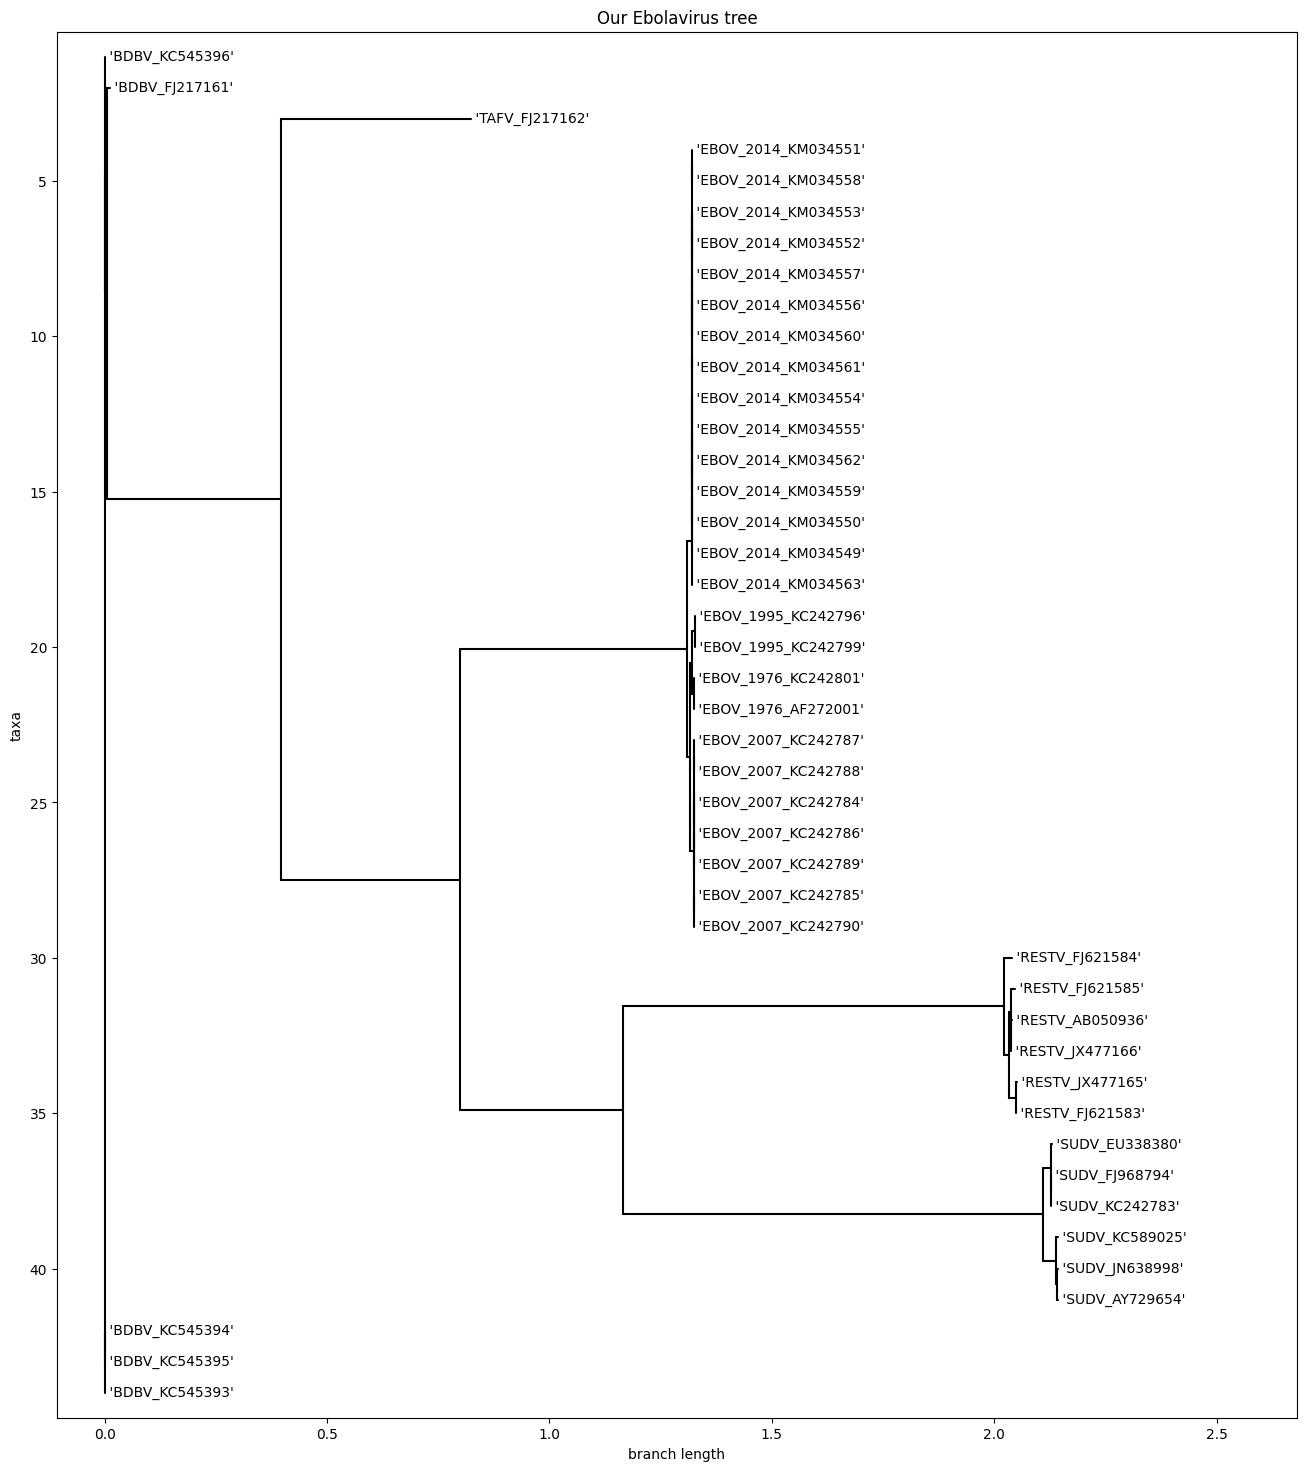

In [15]:
my_ebola_tree = Phylo.read('my_ebola.nex', 'nexus')
my_ebola_tree.name = 'Our Ebolavirus tree'

fig = plt.figure(figsize=(16, 18))
ax = fig.add_subplot(1, 1, 1)
Phylo.draw(my_ebola_tree, axes=ax)

**RaxmlCommandline Object:**

    This line creates an instance of the RaxmlCommandline class (from Biopython’s Phylo applications, or a similar wrapper) that encapsulates the command to run RAxML.

Parameters:

**sequences='trim.fasta':**
    Specifies the input alignment file in FASTA format. Here, trim.fasta is assumed to be an alignment that has been preprocessed (for example, trimmed by TrimAl).

**model='GTRGAMMA':**
    Sets the substitution model to use. The GTRGAMMA model is a standard model for DNA data that combines the General Time Reversible (GTR) model with a gamma distribution to model rate heterogeneity across sites.

**name='biopython':**
    This parameter sets the prefix for output files. RAxML will generate output files with names beginning with "RAxML_" followed by the value provided here (e.g., RAxML_bestTree.biopython).

**num_replicates='10':**
    Specifies that RAxML should run 10 replicates (this might be for bootstrapping or for alternative starting trees, depending on the version and settings).
**Note:** Some versions of RAxML require specific formatting for bootstrap options. In this case, the wrapper accepts a string.

**parsimony_seed=random.randint(0, sys.maxsize):**
    Generates a random seed (using Python’s random.randint) that is passed to RAxML. This seed is used to generate the starting tree using a parsimony approach.

**working_dir=os.getcwd() + os.sep + 'bp_rx':**
    Sets the working directory for the RAxML run. The directory is constructed by taking the current working directory (os.getcwd()), appending the OS-specific separator (os.sep), and adding the folder name 'bp_rx'. On POSIX systems (like Linux, macOS, and other Unix-like systems), os.sep is /.
On Windows systems, os.sep is `\`.

In [2]:
raxml_cline = RaxmlCommandline(sequences='trim.fasta',
                               model='GTRGAMMA', name='biopython',
                               num_replicates='10',
                               parsimony_seed=random.randint(0, sys.maxsize),
                               working_dir=os.getcwd() + os.sep + 'bp_rx')
print(raxml_cline)

raxmlHPC -m GTRGAMMA -n biopython -p 5401075228226300648 -s trim.fasta -w /home/veysel/Veysel_Sapan/Bioinformatics_with_Python_Cookbook/Bioinformatics-with-Python-Cookbook-third-edition/Chapter07/bp_rx -N 10


**out:**
    This variable holds the standard output (stdout) of the RAxML process. In other words, any text that RAxML writes to the console during its run (such as progress messages, summaries, or the final alignment/tree details) is captured here.

**err:**
    This variable holds the standard error (stderr) output of the RAxML process. This typically includes any error messages or warnings that the program might emit.

These two values are returned by the underlying mechanism (usually via a call to something like subprocess.communicate()) when the command finishes executing. They allow you to inspect what RAxML printed normally (out) and any diagnostic messages (err) in case something went wrong.

In [3]:
try:
    os.mkdir('bp_rx')
except OSError:
    shutil.rmtree('bp_rx') # Recursively deletes the directory 'bp_rx' (and all its contents) to ensure a clean start.
    os.mkdir('bp_rx')
out, err = raxml_cline()

biopython_tree = Phylo.read('bp_rx/RAxML_bestTree.biopython', 'newick')

print(biopython_tree)

Tree(rooted=False, weight=1.0)
    Clade(branch_length=0.0)
        Clade(branch_length=0.00015503496938629427)
            Clade(branch_length=0.005793110901332485)
                Clade(branch_length=0.006922425551018542, name='BDBV_FJ217161')
                Clade(branch_length=0.3899189036890066)
                    Clade(branch_length=0.4261498400678875, name='TAFV_FJ217162')
                    Clade(branch_length=0.40155822816459336)
                        Clade(branch_length=0.3659315473182154)
                            Clade(branch_length=0.8548610426516412)
                                Clade(branch_length=0.018171866882938283, name='RESTV_FJ621584')
                                Clade(branch_length=0.011785828702061102)
                                    Clade(branch_length=0.003908450788839599)
                                        Clade(branch_length=0.010827354580434951, name='RESTV_FJ621585')
                                        Clade(branch_length=0.0017483

In [4]:
ebola_raxml = dendropy.Tree.get_from_path('my_ebola.nex', 'nexus')
def compute_level(node, level=0):
    """
    To traverse the tree (using a depth-first approach) and print out 
    information for nodes that have an associated taxon (typically the 
    leaf nodes or annotated internal nodes).
    """
    for child in node.child_nodes():
        compute_level(child, level + 1)
    if node.taxon is not None:
        print("%s: %d %d" % (node.taxon, node.level(), level))

compute_level(ebola_raxml.seed_node)

'BDBV_KC545396': 2 2
'BDBV_FJ217161': 3 3
'TAFV_FJ217162': 4 4
'EBOV_2014_KM034551': 13 13
'EBOV_2014_KM034558': 13 13
'EBOV_2014_KM034553': 14 14
'EBOV_2014_KM034552': 14 14
'EBOV_2014_KM034557': 14 14
'EBOV_2014_KM034556': 15 15
'EBOV_2014_KM034560': 15 15
'EBOV_2014_KM034561': 11 11
'EBOV_2014_KM034554': 11 11
'EBOV_2014_KM034555': 12 12
'EBOV_2014_KM034562': 13 13
'EBOV_2014_KM034559': 13 13
'EBOV_2014_KM034550': 9 9
'EBOV_2014_KM034549': 8 8
'EBOV_2014_KM034563': 7 7
'EBOV_1995_KC242796': 9 9
'EBOV_1995_KC242799': 9 9
'EBOV_1976_KC242801': 9 9
'EBOV_1976_AF272001': 9 9
'EBOV_2007_KC242787': 10 10
'EBOV_2007_KC242788': 10 10
'EBOV_2007_KC242784': 10 10
'EBOV_2007_KC242786': 11 11
'EBOV_2007_KC242789': 11 11
'EBOV_2007_KC242785': 9 9
'EBOV_2007_KC242790': 9 9
'RESTV_FJ621584': 7 7
'RESTV_FJ621585': 9 9
'RESTV_AB050936': 10 10
'RESTV_JX477166': 10 10
'RESTV_JX477165': 9 9
'RESTV_FJ621583': 9 9
'SUDV_EU338380': 8 8
'SUDV_FJ968794': 9 9
'SUDV_KC242783': 9 9
'SUDV_KC589025': 8 8
'SUDV_J

In [5]:
def compute_height(node):
    """
    To calculate the height of the tree (or subtree) rooted at node. 
    The height is the number of edges on the longest downward path from the node to a leaf.
    The function is a post-order recursive function: it first computes the height of all 
    child nodes, then uses those values to compute the height for the current node.
    At a leaf, the height is 0.
    At an internal node, the height is 1 plus the maximum height of its children.
    """
    children = node.child_nodes()
    if len(children) == 0:
        height = 0
    else:
        height = 1 + max(map(lambda x: compute_height(x), children))
    desc = node.taxon or 'Internal'
    print("%s: %d %d" % (desc, height, node.level()))
    return height

compute_height(ebola_raxml.seed_node)

'BDBV_KC545396': 0 2
'BDBV_FJ217161': 0 3
'TAFV_FJ217162': 0 4
'EBOV_2014_KM034551': 0 13
'EBOV_2014_KM034558': 0 13
Internal: 1 12
'EBOV_2014_KM034553': 0 14
'EBOV_2014_KM034552': 0 14
Internal: 1 13
'EBOV_2014_KM034557': 0 14
'EBOV_2014_KM034556': 0 15
'EBOV_2014_KM034560': 0 15
Internal: 1 14
Internal: 2 13
Internal: 3 12
Internal: 4 11
'EBOV_2014_KM034561': 0 11
Internal: 5 10
'EBOV_2014_KM034554': 0 11
'EBOV_2014_KM034555': 0 12
'EBOV_2014_KM034562': 0 13
'EBOV_2014_KM034559': 0 13
Internal: 1 12
Internal: 2 11
Internal: 3 10
Internal: 6 9
'EBOV_2014_KM034550': 0 9
Internal: 7 8
'EBOV_2014_KM034549': 0 8
Internal: 8 7
'EBOV_2014_KM034563': 0 7
Internal: 9 6
'EBOV_1995_KC242796': 0 9
'EBOV_1995_KC242799': 0 9
Internal: 1 8
'EBOV_1976_KC242801': 0 9
'EBOV_1976_AF272001': 0 9
Internal: 1 8
Internal: 2 7
'EBOV_2007_KC242787': 0 10
'EBOV_2007_KC242788': 0 10
Internal: 1 9
'EBOV_2007_KC242784': 0 10
'EBOV_2007_KC242786': 0 11
'EBOV_2007_KC242789': 0 11
Internal: 1 10
Internal: 2 9
Inter

15

In [11]:
def compute_nofs(node):
    """
    This function is intended to traverse the tree (in a depth‐first manner) and print out, 
    for each node with a taxon (or an internal node labeled as “Internal”), two pieces of 
    information:
    The number of immediate children (offspring) it has.
    The node’s level (depth) as computed by DendroPy.
    """
    children = node.child_nodes()
    nofs = len(children)
    #map(lambda x: compute_nofs(x), children)
    for child in children:
        compute_nofs(child)
    desc = node.taxon or 'Internal'
    print("%s: %d %d" % (desc, nofs, node.level()))

compute_nofs(ebola_raxml.seed_node)

'BDBV_KC545396': 0 2
'BDBV_FJ217161': 0 3
'TAFV_FJ217162': 0 4
'EBOV_2014_KM034551': 0 13
'EBOV_2014_KM034558': 0 13
Internal: 2 12
'EBOV_2014_KM034553': 0 14
'EBOV_2014_KM034552': 0 14
Internal: 2 13
'EBOV_2014_KM034557': 0 14
'EBOV_2014_KM034556': 0 15
'EBOV_2014_KM034560': 0 15
Internal: 2 14
Internal: 2 13
Internal: 2 12
Internal: 2 11
'EBOV_2014_KM034561': 0 11
Internal: 2 10
'EBOV_2014_KM034554': 0 11
'EBOV_2014_KM034555': 0 12
'EBOV_2014_KM034562': 0 13
'EBOV_2014_KM034559': 0 13
Internal: 2 12
Internal: 2 11
Internal: 2 10
Internal: 2 9
'EBOV_2014_KM034550': 0 9
Internal: 2 8
'EBOV_2014_KM034549': 0 8
Internal: 2 7
'EBOV_2014_KM034563': 0 7
Internal: 2 6
'EBOV_1995_KC242796': 0 9
'EBOV_1995_KC242799': 0 9
Internal: 2 8
'EBOV_1976_KC242801': 0 9
'EBOV_1976_AF272001': 0 9
Internal: 2 8
Internal: 2 7
'EBOV_2007_KC242787': 0 10
'EBOV_2007_KC242788': 0 10
Internal: 2 9
'EBOV_2007_KC242784': 0 10
'EBOV_2007_KC242786': 0 11
'EBOV_2007_KC242789': 0 11
Internal: 2 10
Internal: 2 9
Inter

In [7]:
def print_nodes(node):
    """
    This function performs a depth‐first traversal (post-order) and prints the 
    taxon label and the level of every node that has a taxon. This is typically 
    used to print information for leaf nodes, but may also print for internal 
    nodes if they carry taxon labels.
    """
    for child in node.child_nodes():
        print_nodes(child)
    if node.taxon is not None:
        print('%s (%d)' % (node.taxon, node.level()))

print_nodes(ebola_raxml.seed_node)

'BDBV_KC545396' (2)
'BDBV_FJ217161' (3)
'TAFV_FJ217162' (4)
'EBOV_2014_KM034551' (13)
'EBOV_2014_KM034558' (13)
'EBOV_2014_KM034553' (14)
'EBOV_2014_KM034552' (14)
'EBOV_2014_KM034557' (14)
'EBOV_2014_KM034556' (15)
'EBOV_2014_KM034560' (15)
'EBOV_2014_KM034561' (11)
'EBOV_2014_KM034554' (11)
'EBOV_2014_KM034555' (12)
'EBOV_2014_KM034562' (13)
'EBOV_2014_KM034559' (13)
'EBOV_2014_KM034550' (9)
'EBOV_2014_KM034549' (8)
'EBOV_2014_KM034563' (7)
'EBOV_1995_KC242796' (9)
'EBOV_1995_KC242799' (9)
'EBOV_1976_KC242801' (9)
'EBOV_1976_AF272001' (9)
'EBOV_2007_KC242787' (10)
'EBOV_2007_KC242788' (10)
'EBOV_2007_KC242784' (10)
'EBOV_2007_KC242786' (11)
'EBOV_2007_KC242789' (11)
'EBOV_2007_KC242785' (9)
'EBOV_2007_KC242790' (9)
'RESTV_FJ621584' (7)
'RESTV_FJ621585' (9)
'RESTV_AB050936' (10)
'RESTV_JX477166' (10)
'RESTV_JX477165' (9)
'RESTV_FJ621583' (9)
'SUDV_EU338380' (8)
'SUDV_FJ968794' (9)
'SUDV_KC242783' (9)
'SUDV_KC589025' (8)
'SUDV_JN638998' (9)
'SUDV_AY729654' (9)
'BDBV_KC545394' (2)
'BDBV

In [8]:
def print_breadth(tree):
    """
    This function performs a breadth-first (level-order) traversal of the tree and 
    prints nodes that have a taxon, along with their levels. Nodes are processed 
    level-by-level, starting from the root and moving downward.
    """
    queue = deque()
    queue.append(tree.seed_node) # The root (seed node) of the tree is added to the queue.
    while len(queue) > 0:
        process_node = queue.popleft() # pops the leftmost node (FIFO order)
        if process_node.taxon is not None:
            print('%s (%d)' % (process_node.taxon, process_node.level()))
        else:
            for child in process_node.child_nodes():
                queue.append(child)

print_breadth(ebola_raxml)

'BDBV_KC545393' (1)
'BDBV_KC545396' (2)
'BDBV_KC545394' (2)
'BDBV_KC545395' (2)
'BDBV_FJ217161' (3)
'TAFV_FJ217162' (4)
'EBOV_2014_KM034563' (7)
'RESTV_FJ621584' (7)
'EBOV_2014_KM034549' (8)
'SUDV_EU338380' (8)
'SUDV_KC589025' (8)
'EBOV_2014_KM034550' (9)
'EBOV_1995_KC242796' (9)
'EBOV_1995_KC242799' (9)
'EBOV_1976_KC242801' (9)
'EBOV_1976_AF272001' (9)
'EBOV_2007_KC242785' (9)
'EBOV_2007_KC242790' (9)
'RESTV_FJ621585' (9)
'RESTV_JX477165' (9)
'RESTV_FJ621583' (9)
'SUDV_FJ968794' (9)
'SUDV_KC242783' (9)
'SUDV_JN638998' (9)
'SUDV_AY729654' (9)
'EBOV_2007_KC242787' (10)
'EBOV_2007_KC242788' (10)
'EBOV_2007_KC242784' (10)
'RESTV_AB050936' (10)
'RESTV_JX477166' (10)
'EBOV_2014_KM034561' (11)
'EBOV_2014_KM034554' (11)
'EBOV_2007_KC242786' (11)
'EBOV_2007_KC242789' (11)
'EBOV_2014_KM034555' (12)
'EBOV_2014_KM034551' (13)
'EBOV_2014_KM034558' (13)
'EBOV_2014_KM034562' (13)
'EBOV_2014_KM034559' (13)
'EBOV_2014_KM034553' (14)
'EBOV_2014_KM034552' (14)
'EBOV_2014_KM034557' (14)
'EBOV_2014_KM0345

In [9]:
from copy import deepcopy
simple_ebola = deepcopy(ebola_raxml)

def simplify_tree(node):
    prefs = set()
    for leaf in node.leaf_nodes():
        my_toks = leaf.taxon.label.split(' ')[0].split('_')
        if my_toks[0] == 'EBOV':
            prefs.add('EBOV' + my_toks[1])
        else:
            prefs.add(my_toks[0])
    if len(prefs) == 1:
        print(prefs, len(node.leaf_nodes()))
        node.taxon = dendropy.Taxon(label=list(prefs)[0])
        #node.collapse_clade()
        node.set_child_nodes([])
    else:
        for child in node.child_nodes():
            simplify_tree(child)

simplify_tree(simple_ebola.seed_node)
simple_ebola.ladderize()
simple_ebola.write_to_path('ebola_simple.nex', 'nexus')

{'BDBV'} 1
{'BDBV'} 1
{'TAFV'} 1
{'EBOV2014'} 15
{'EBOV1995'} 2
{'EBOV1976'} 2
{'EBOV2007'} 7
{'RESTV'} 6
{'SUDV'} 6
{'BDBV'} 2
{'BDBV'} 1


 , BDBV
 |
 | BDBV
_|
 , BDBV
 |
 , BDBV
 |
 |            _____________ TAFV
 |           |
 |___________|                         __________________________ RESTV
             |             ___________|
             |            |           |_____________________________ SUDV
             |____________|
                          |               , EBOV2014
                          |_______________|
                                          , EBOV2007
                                          |
                                          , EBOV1995
                                          |
                                          | EBOV1976

 , 'BDBV_KC545396'
 |
 , 'BDBV_FJ217161'
 |
 |         __________ 'TAFV_FJ217162'
 |        |
 |        |                      , 'EBOV_2014_KM034551'
 |        |                      |
 |        |                      | 'EBOV_2014_KM034558'
 |        |                      |
 |        |                      , 'EBOV_2014_KM034553'
 |        |      

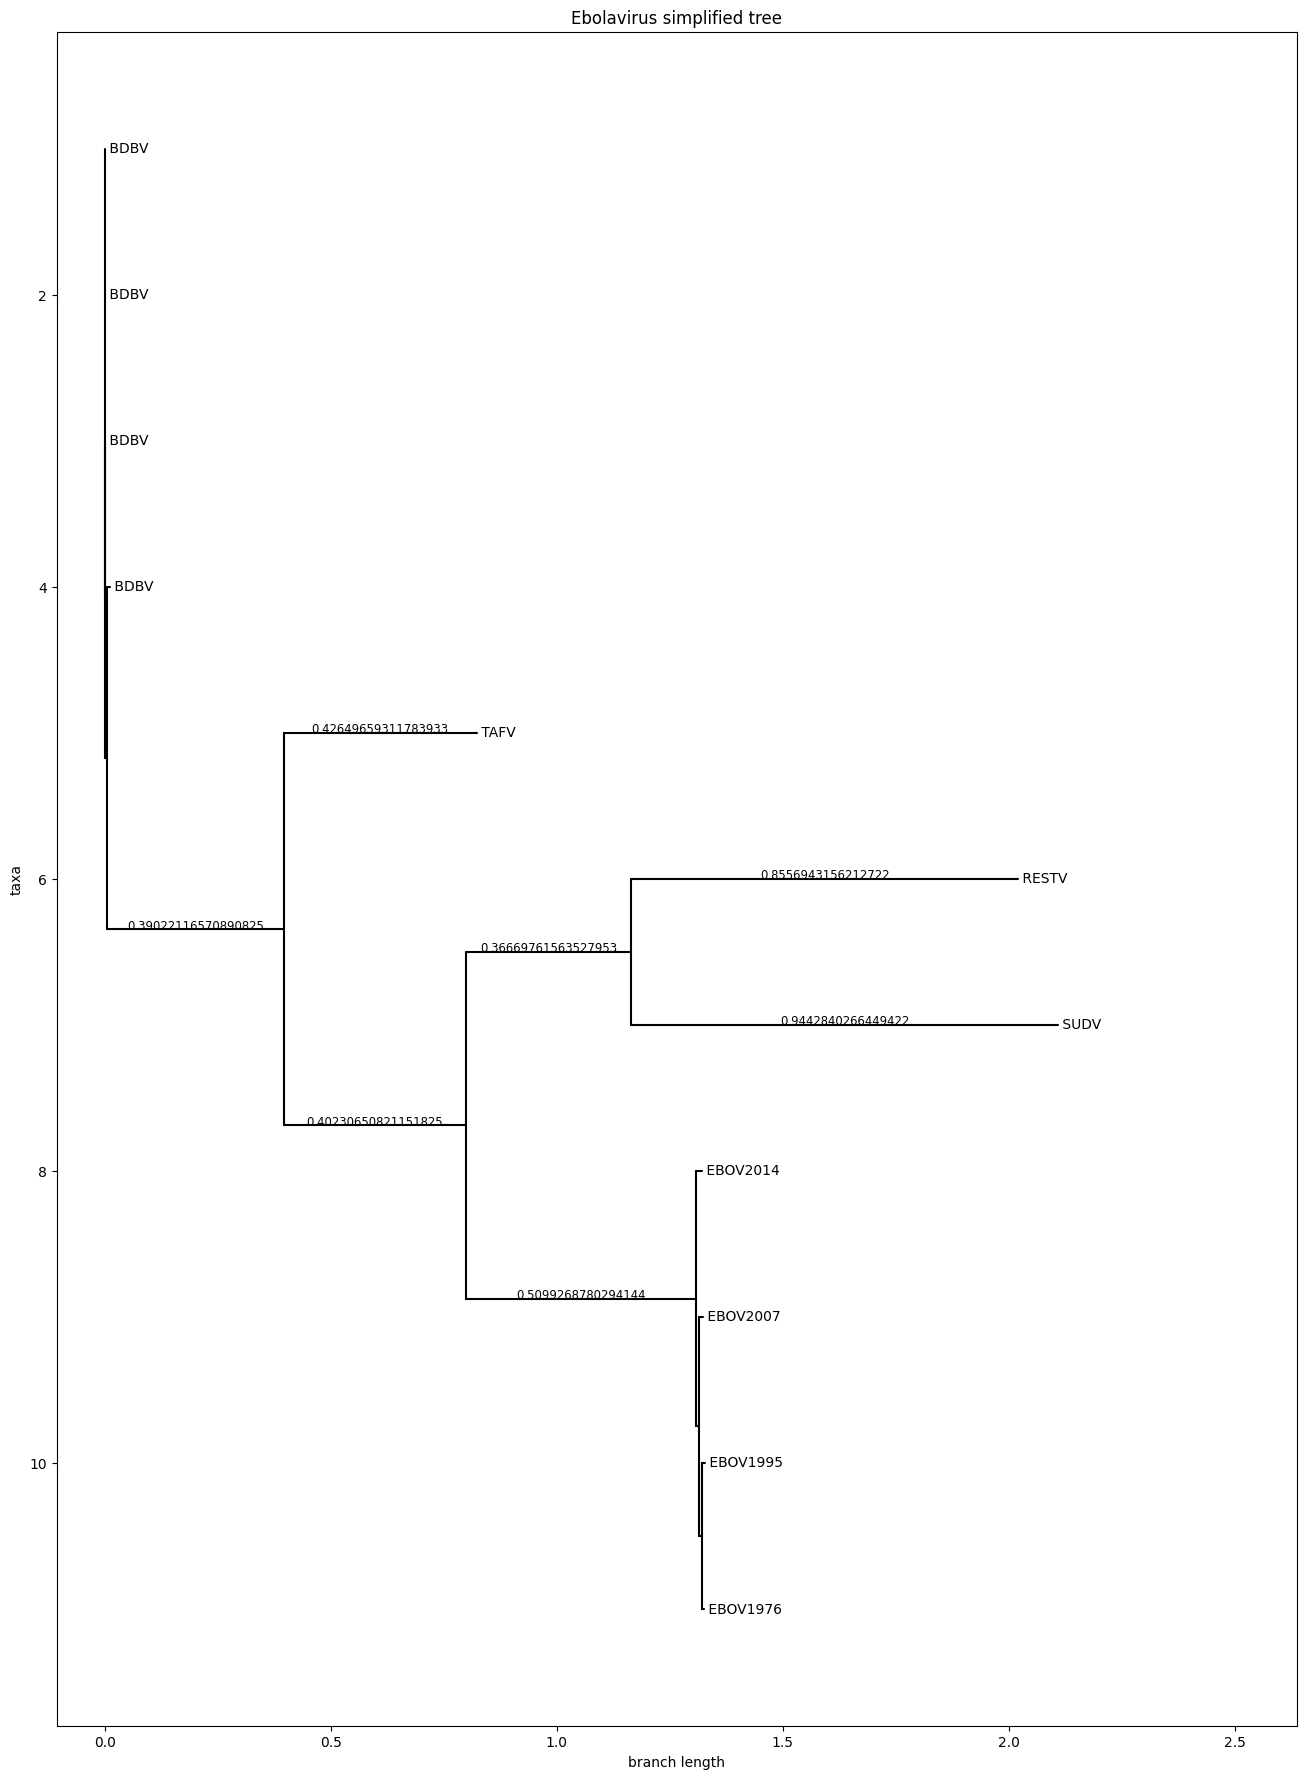

In [12]:
ebola_tree = Phylo.read('my_ebola.nex', 'nexus')
ebola_tree.name = 'Ebolavirus tree'
ebola_simple_tree = Phylo.read('ebola_simple.nex', 'nexus')
ebola_simple_tree.name = 'Ebolavirus simplified tree'

Phylo.draw_ascii(ebola_simple_tree)
Phylo.draw_ascii(ebola_tree)

fig = plt.figure(figsize=(16, 22))
ax = fig.add_subplot(111)
Phylo.draw(ebola_simple_tree, axes=ax, branch_labels=
           lambda c: c.branch_length if c.branch_length > 0.02 else None)

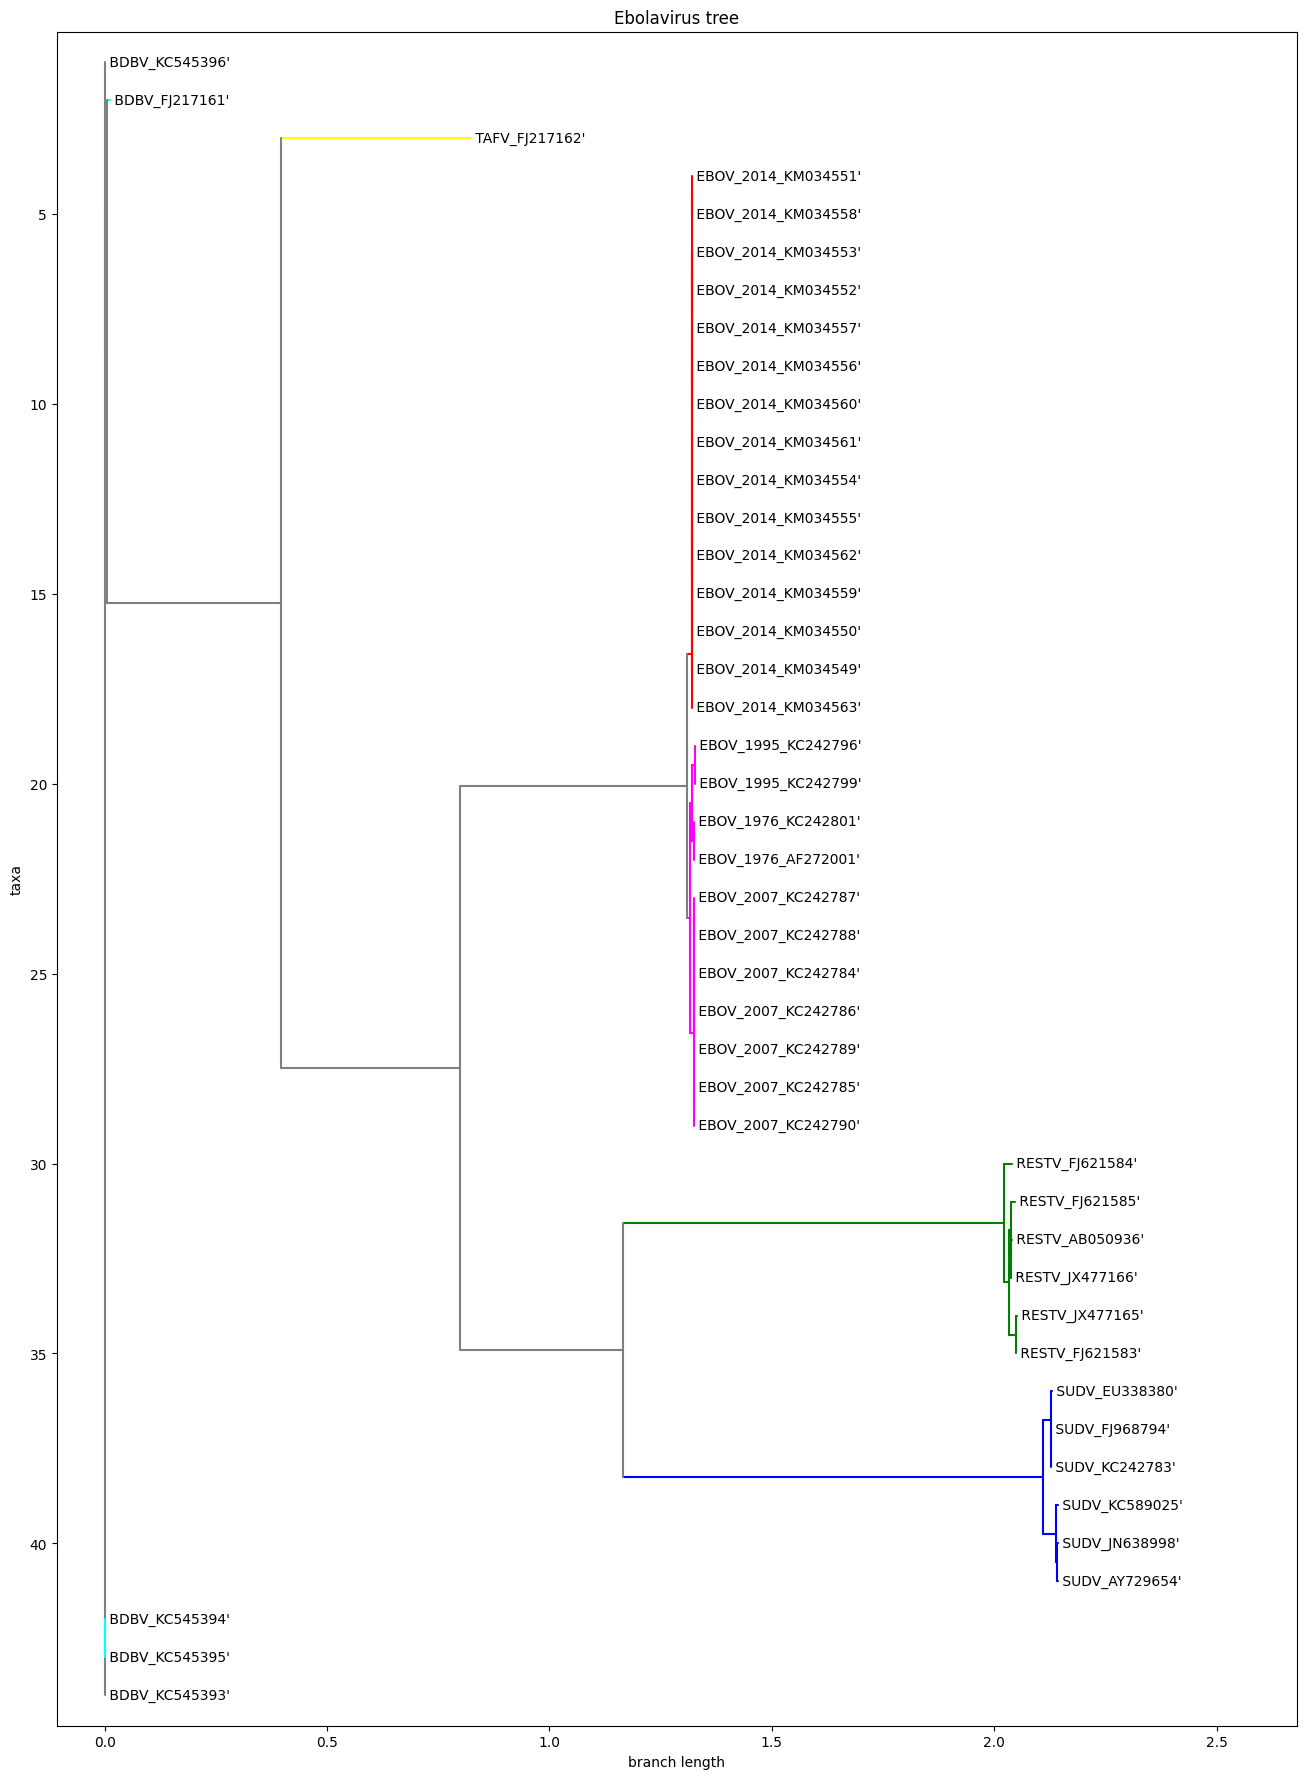

In [13]:
fig = plt.figure(figsize=(16, 22))
ax = fig.add_subplot(111)
my_colors = OrderedDict({
'EBOV_2014': 'red',
'EBOV': 'magenta',
'BDBV': 'cyan',
'SUDV': 'blue',
'RESTV' : 'green',
'TAFV' : 'yellow'
})

def get_color(name):
    for pref, color in my_colors.items():
        if name.find(pref) > -1:
            return color
    return 'grey'

def color_tree(node, fun_color=get_color):
    if node.is_terminal():
        node.color = fun_color(node.name)
    else:
        my_children = set()
        for child in node.clades:
            color_tree(child, fun_color)
            my_children.add(child.color.to_hex())
        if len(my_children) == 1:
            node.color = child.color
        else:
            node.color = 'grey'

ebola_color_tree = deepcopy(ebola_tree)
color_tree(ebola_color_tree.root)
Phylo.draw(ebola_color_tree, axes=ax, label_func=
           lambda x: x.name.split(' ')[0][1:] if x.name is not None else None)